In [1]:
import zipfile
import pandas as pd
import os
import geopandas as gp
from scipy.cluster.vq import kmeans2
from scipy.cluster.vq import whiten
import numpy as np
import datetime
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataDir = '/Users/michelleho/PUI2015_mmh555/HW10/DATA'
dfs = {}
for subdir, dirs, files in os.walk(dataDir):
    for file in files[1:]:
        zf = zipfile.ZipFile(dataDir+'/'+file)
        dfs['{}'.format(os.path.splitext(file)[0][3:5]+'DF')] = pd.read_csv(zf.open(file.replace('.zip','.txt')))

In [4]:
for x in dfs.keys():
    try:
        dfs['{}'.format(x)] = dfs['{}'.format(x)][['ZIP','EST']]
        dfs['{}'.format(x)].rename(columns={'EST': '{}'.format(x[0:2])}, inplace=True)

    except KeyError:
            dfs['{}'.format(x)] = dfs['{}'.format(x)][['zip','est']]
            dfs['{}'.format(x)].rename(columns={'zip': 'ZIP', 'est': '{}'.format(x[0:2])}, inplace=True)
    print dfs['{}'.format(x)].columns

Index([u'ZIP', u'06'], dtype='object')
Index([u'ZIP', u'05'], dtype='object')
Index([u'ZIP', u'02'], dtype='object')
Index([u'ZIP', u'03'], dtype='object')
Index([u'ZIP', u'99'], dtype='object')
Index([u'ZIP', u'94'], dtype='object')
Index([u'ZIP', u'13'], dtype='object')
Index([u'ZIP', u'07'], dtype='object')
Index([u'ZIP', u'97'], dtype='object')
Index([u'ZIP', u'10'], dtype='object')
Index([u'ZIP', u'98'], dtype='object')
Index([u'ZIP', u'08'], dtype='object')
Index([u'ZIP', u'12'], dtype='object')
Index([u'ZIP', u'95'], dtype='object')
Index([u'ZIP', u'11'], dtype='object')
Index([u'ZIP', u'04'], dtype='object')
Index([u'ZIP', u'96'], dtype='object')
Index([u'ZIP', u'09'], dtype='object')


/Users/michelleho/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [5]:
dfMergeExample = pd.merge(dfs['02DF'], dfs['03DF'], on='ZIP', how = 'inner')

In [6]:
#Putting dataframes into List in order to reduce, not sure why but now it works!
dfsList = []
for x in dfs.keys():
    dfsList.append(dfs['{}'.format(x)])

In [7]:
len(dfsList)
#I am missing 2000 and 2001 data, therefore we have 18 datasets, not 20.

18

In [8]:
df_final = reduce(lambda left, right: pd.merge(left, right, on='ZIP', how = 'inner'), dfsList)

In [9]:
shapeData = gp.read_file('NYCzipcodeshapefile2.geojson')

In [10]:
shapeData.rename(columns = {'postalCode':'ZIP'}, inplace=True)

In [252]:
#Making sure the ZIP is a float in the shapeData, so we can join it with the establishment data
shapeData['ZIP'] = shapeData['ZIP'].astype(float)
print type(shapeData['ZIP'][0])

<type 'numpy.float64'>


In [273]:
myData_merged = pd.merge(df_final, shapeData, on = 'ZIP', how = 'inner')
myData = myData_merged[myData_merged.columns[1:19]] #removed the column of ZIP codes, maybe consider setting as index later
print type(myData)
zips = myData_merged['ZIP']

<class 'pandas.core.frame.DataFrame'>


In [274]:
#Renaming column headers to full year
for x in myData:
    myData.rename(columns = {'{}'.format(x):datetime.datetime.strptime('{}'.format(x), "%y").year}, inplace=True)

In [277]:
#Sorting dataframe by column header to get time series
myData = myData.reindex_axis(sorted(myData.columns),axis=1)
myData.head()

,1994,1995,1996,1997,1998,1999,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,6999,7088,7075,7154,7254,7233,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
1,1784,1819,1919,2049,2003,2085,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
2,3256,3377,3417,3535,3649,3659,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
3,1115,1124,1133,1173,1176,1233,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
4,1115,1124,1133,1173,1176,1233,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479


In [278]:
print np.asarray(myData.loc[0])
print len(myData)

[6999 7088 7075 7154 7254 7233 7141 7084 7370 7312 7415 7549 7472 7305 7241
 7227 7235 7273]
243


In [279]:
#Normalize across the time series
for i in range(len(myData)):
    zipMean = myData.loc[i].mean()
    zipSTD = myData.loc[i].std()
    myData.loc[i] = (np.asarray(myData.loc[i]) - zipMean)/zipSTD

In [280]:
#Sanity check: means should be near zero and standard deviations near one.
# for i in range(len(myData)):
#     print myData.loc[i].mean()
#     print myData.loc[i].std()

Nzipcodes = myData.shape[0]
Ntimestamps = myData.shape[1]
print "Number of zip codes: ", Nzipcodes
print "Number of time stamps: ", Ntimestamps

Number of zip codes:  243
Number of time stamps:  18


In [281]:
type(np.asarray(myData))

numpy.ndarray

In [282]:
nk= 5
cluster_centroids, closest_centroids = kmeans2(np.asarray(myData), 5, iter=15, minit = 'points')

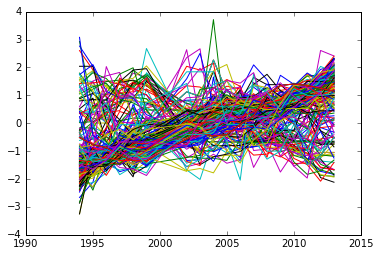

In [283]:
#Plotting all the time series together
for i in range(len(myData)):
    pl.plot(myData.loc[i])

In [284]:
print cluster_centroids.shape
#
dates = [1994, 1995, 1996, 1997, 1998, 1999, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
#print(dates)
cluster_centroidsDF = pd.DataFrame(cluster_centroids, columns = dates)

(5, 18)


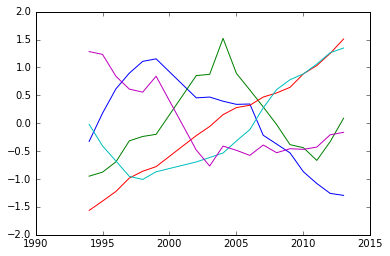

In [285]:
for i in range(0,5):
    pl.plot(cluster_centroidsDF.loc[i])

In [286]:
cluster_myData = myData.join(pd.Series(closest_centroids, name = 'Cluster Number'))

In [287]:
cluster_myData.head()

,1994,1995,1996,1997,1998,1999,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,Cluster Number
0,-1.703900,-1.089806,-1.179505,-0.634410,0.055583,-0.089316,-0.724109,-1.117406,0.855975,0.455779,1.166472,2.091063,1.559768,0.407479,-0.034116,-0.130715,-0.075516,0.186681,2
1,-1.608752,-1.524391,-1.283359,-0.970018,-1.080893,-0.883247,-0.439749,-0.119177,0.239960,0.555712,0.565353,0.562943,0.577404,0.779871,1.013672,1.110084,1.211317,1.293268,2
2,-1.814413,-1.424651,-1.295805,-0.915707,-0.548493,-0.516282,-0.654792,-0.371329,-0.139405,0.153721,0.289010,0.739974,0.810840,0.901032,0.946129,1.094303,1.271467,1.474401,2
3,-1.502790,-1.424029,-1.345267,-0.995216,-0.968962,-0.470138,-0.295113,-0.303864,-0.032574,-0.233854,0.212462,0.728788,0.781295,0.807549,0.973824,1.026331,1.358880,1.682678,2
4,-1.502790,-1.424029,-1.345267,-0.995216,-0.968962,-0.470138,-0.295113,-0.303864,-0.032574,-0.233854,0.212462,0.728788,0.781295,0.807549,0.973824,1.026331,1.358880,1.682678,2


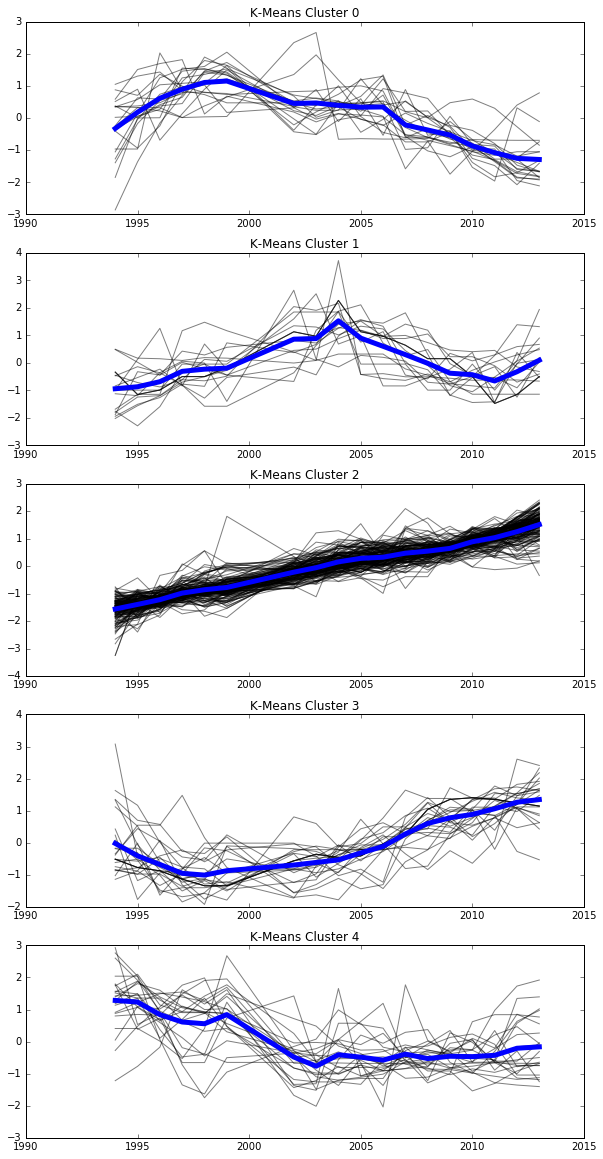

In [288]:
fig = pl.figure(figsize=(10,20))
ax = []
for i in range(0,5):
    ax.append(fig.add_subplot(5,1,i+1))
for i in range(len(myData)):
    cluster = int(cluster_myData.loc[i,'Cluster Number'])
    ax[cluster].plot(cluster_myData.loc[i,dates],'k', alpha = 0.5)
for i in range(0,5):
    ax[i].plot(cluster_centroidsDF.loc[i], linewidth=5)
    ax[i].set_title('K-Means Cluster {}'.format(i))

In [289]:
from sklearn.cluster import DBSCAN

In [290]:
db = DBSCAN(eps=.9, min_samples=2).fit(myData)
labels = (db.labels_).astype(int)
print labels
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#clusters = pd.Series([myData[labels == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)

[-1  0  0  0  0  0  0 -1 -1 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  0  0  0 -1  0  0  0  0  0  0  0  0 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0  0  0  0
  0  0  0 -1 -1  0 -1  0  0  0  0  0  0 -1  0  0 -1 -1  0  0  1  1  1 -1 -1
 -1 -1  0 -1 -1  0 -1 -1  0 -1 -1 -1 -1  2  2 -1  0  0  0  0  0  0 -1  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0 -1  0  0 -1  0  0  0 -1  0 -1 -1  0  0 -1  0  0 -1  0  0  0
  3  3 -1  0  0  0 -1  0  0  0  0 -1  0  0 -1  0 -1 -1 -1  0  0  0 -1  0 -1
  0 -1 -1 -1  0 -1  0  0  0 -1  0 -1  4  4  4  4 -1 -1]
Number of clusters: 5


In [304]:
cluster_myData2 = myData.join(pd.Series(labels, name = 'DBSCAN Cluster Number'))

In [305]:
cluster_myData2['DBSCAN Cluster Number'] = cluster_myData2['DBSCAN Cluster Number']+1
print cluster_myData2.head()
print labels

       1994      1995      1996      1997      1998      1999      2002  \
0 -1.703900 -1.089806 -1.179505 -0.634410  0.055583 -0.089316 -0.724109   
1 -1.608752 -1.524391 -1.283359 -0.970018 -1.080893 -0.883247 -0.439749   
2 -1.814413 -1.424651 -1.295805 -0.915707 -0.548493 -0.516282 -0.654792   
3 -1.502790 -1.424029 -1.345267 -0.995216 -0.968962 -0.470138 -0.295113   
4 -1.502790 -1.424029 -1.345267 -0.995216 -0.968962 -0.470138 -0.295113   

       2003      2004      2005      2006      2007      2008      2009  \
0 -1.117406  0.855975  0.455779  1.166472  2.091063  1.559768  0.407479   
1 -0.119177  0.239960  0.555712  0.565353  0.562943  0.577404  0.779871   
2 -0.371329 -0.139405  0.153721  0.289010  0.739974  0.810840  0.901032   
3 -0.303864 -0.032574 -0.233854  0.212462  0.728788  0.781295  0.807549   
4 -0.303864 -0.032574 -0.233854  0.212462  0.728788  0.781295  0.807549   

       2010      2011      2012      2013  DBSCAN Cluster Number  
0 -0.034116 -0.130715 -0.075516

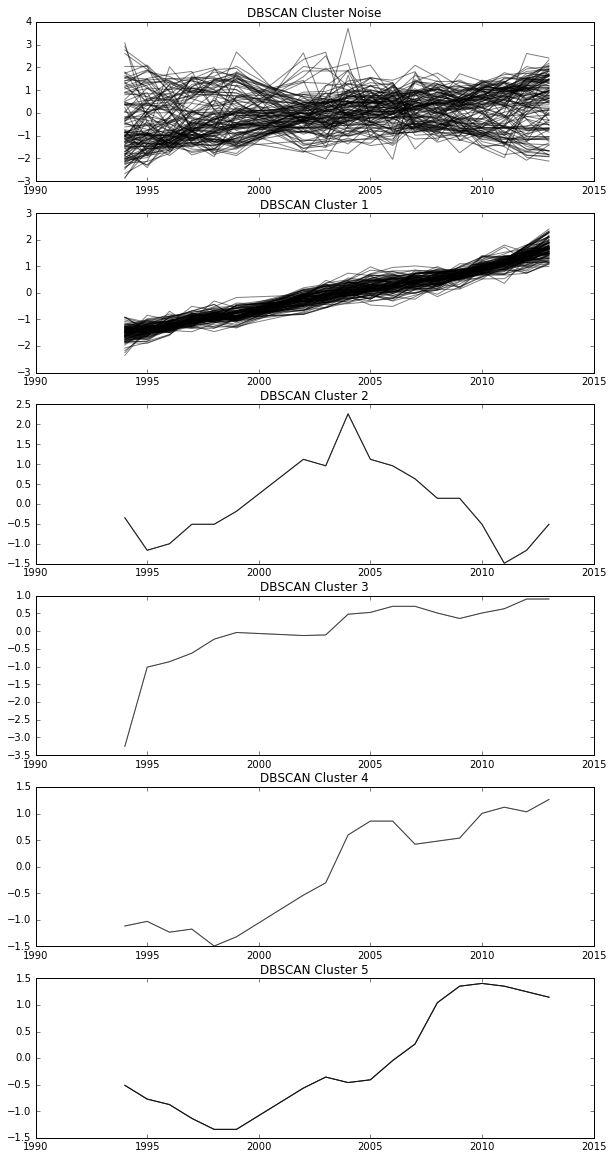

In [313]:
fig = pl.figure(figsize=(10,20))
ax = []
for i in range(0,6):
    ax.append(fig.add_subplot(6,1,i+1))
for i in range(len(cluster_myData2)):
    cluster = int(cluster_myData2.loc[i,'DBSCAN Cluster Number'])
    ax[cluster].plot(cluster_myData2.loc[i,dates],'k', alpha = 0.5)
for i in range(1,6):
    #ax[i].plot(cluster_centroidsDF.loc[i], linewidth=5)
    ax[i].set_title('DBSCAN Cluster {}'.format(i))
ax[0].set_title('DBSCAN Cluster Noise')

In [399]:
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import urllib2
import json
url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson"
request = urllib2.urlopen(url)
nycShape2 = json.load(request)

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [400]:
import matplotlib.pyplot as plt
from descartes import PolygonPatch
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

mydata2 = cluster_myData.join(pd.Series(zips, name = 'zips'))

fig = plt.figure(figsize=(15,15))
for i in shapeData:
    poly = i['geometry']
    postcode = str(i['properties']['postalCode'])
    ax = fig.gca()
#     GREEN = kelly_colors_hex[19]
#    color = kelly_colors_hex[2]
#   ax.add_patch(PolygonPatch(poly))
    if postcode in list(set(mydata2['zips'])):
        color = kelly_colors_hex[int(mydata2[mydata2['zips']==postcode]['Cluster Number'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
#     else:
#         ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
#ax.axis('scaled')
#import matplotlib.patches as mpatches

#ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
#patch0 = mpatches.Patch(color=kelly_colors_hex[1], alpha=0.5, label='Cluster 0')
#patch1 = mpatches.Patch(color=kelly_colors_hex[2], alpha=0.5, label='Cluster 1')
#patch2 = mpatches.Patch(color=kelly_colors_hex[3], alpha=0.5, label='Cluster 2')
#plt.legend(handles=[ground,patch0,patch1,patch2],loc='best')
#plt.title('3 Clusters: Kmeans Clustering')

TypeError: string indices must be integers

In [353]:
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import matplotlib as mpl
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

In [562]:
myData_merged = pd.merge(df_final, shapeData, on = 'ZIP', how = 'inner')

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,ZIP
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,20163283.874400,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,22606526.913900,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6269333.412340,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,49418364.057700,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,69385865.594300,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365
5,http://nyc.pediacities.com/Resource/PostalCode...,0,081,6,Elmhurst,NY,36,42659399.898200,33755.870988,Queens,POLYGON ((-73.88722098467157 40.72752618766134...,11373
6,http://nyc.pediacities.com/Resource/PostalCode...,0,081,7,Floral Park,NY,36,9155180.262630,13594.924549,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11001
7,http://nyc.pediacities.com/Resource/PostalCode...,0,081,8,Forest Hills,NY,36,55587771.835000,36277.076839,Queens,"POLYGON ((-73.8562474640478 40.7367227854824, ...",11375
8,http://nyc.pediacities.com/Resource/PostalCode...,0,081,9,Queens Village,NY,36,39568339.274800,31231.968593,Queens,POLYGON ((-73.74168681424477 40.73682340115314...,11427
9,http://nyc.pediacities.com/Resource/PostalCode...,0,081,10,Rego Park,NY,36,25203458.868900,26323.994393,Queens,POLYGON ((-73.86451198956482 40.73407164841783...,11374


In [561]:
#shapeDataZips = []
#shapeDataPolygons = []
for i in range(len(shapeData)):
    shapeDataZips.append(shapeData['ZIP'][i])
    shapeDataPolygons.append(shapeData['geometry'][i])
shapeDataCut = np.asarray([shapeDataZips,shapeDataPolygons])
    #print "cluster", zipsANDclusters.loc[zipsANDclusters['zips']==i]['Cluster Number']

In [521]:
for i in range(len(shapeData)):
    poly = shapeData['geometry'][i]
    postcode = shapeData['ZIP'][i]
    if postcode in list(set(mydata2['zips'])):
        print postcode, "is in cluster ", int(zipsANDclusters.loc[zipsANDclusters['zips']==postcode]['Cluster Number'])
    else:
        print postcode, "not in dataset"

11372.0 is in cluster  2
11004.0 is in cluster  2
11040.0 is in cluster  3
11426.0 is in cluster  3
11365.0 is in cluster  2
11373.0 is in cluster  2
11001.0 is in cluster  3
11375.0 is in cluster  2
11427.0 is in cluster  2
11374.0 is in cluster  2
11366.0 is in cluster  2
11423.0 is in cluster  2
11428.0 is in cluster  2
11432.0 is in cluster  2
11379.0 is in cluster  2
11429.0 is in cluster  2
11435.0 is in cluster  2
11415.0 is in cluster  2
11418.0 is in cluster  2
11433.0 is in cluster  2
11451.0 is in cluster  1
11221.0 is in cluster  2
11421.0 is in cluster  2
11419.0 is in cluster  2
11434.0 is in cluster  2
11216.0 is in cluster  2
11416.0 is in cluster  2
11233.0 is in cluster  2
11436.0 is in cluster  2
11213.0 is in cluster  2
11212.0 is in cluster  2
11225.0 is in cluster  2
11218.0 is in cluster  2
11226.0 is in cluster  2
11219.0 is in cluster  2
11210.0 is in cluster  2
11230.0 is in cluster  2
11204.0 is in cluster  2
10471.0 is in cluster  3
10470.0 is in cluster  4


TypeError: cannot convert the series to <type 'int'>

In [502]:
zipsANDclusters = mydata2[['zips','Cluster Number']]
print zipsANDclusters

       zips  Cluster Number
0    10001               2
1    10002               2
2    10003               2
3    10004               2
4    10004               2
5    10004               2
6    10004               2
7    10005               2
8    10006               4
9    10007               1
10   10009               2
11   10010               0
12   10011               2
13   10012               2
14   10013               4
15   10014               2
16   10016               1
17   10017               4
18   10018               2
19   10019               0
20   10020               1
21   10021               0
22   10022               0
23   10023               2
24   10024               2
25   10025               2
26   10026               2
27   10027               2
28   10028               1
29   10029               2
..     ...             ...
213  11413               2
214  11414               1
215  11415               2
216  11416               2
217  11417               3


In [498]:
print np.asarray(zipsANDclusters.loc[1])[1]

2


POLYGON ((-73.93739763108535 40.67972992244106, -73.92905727071383 40.67927645406513, -73.93020074773672 40.67804022252579, -73.93045708472673 40.67581876680987, -73.92768791018021 40.67566288431892, -73.92776143466391 40.67488742035348, -73.92499590519674 40.67473589594239, -73.92580501111077 40.666456157208, -73.925653595542 40.66582990624871, -73.93065206871213 40.66363834202987, -73.93726377174885 40.66319183016009, -73.93715846706962 40.66375261786932, -73.94269628450726 40.66405515298856, -73.94252842813368 40.66583793996203, -73.94806707556559 40.66613891733024, -73.94714602322288 40.67594438109577, -73.94160931928725 40.67564320442343, -73.94120864001327 40.67993836946285, -73.93739763108535 40.67972992244106))


(-73.950000000000003, -73.920000000000002, 40.661999999999999, 40.68)

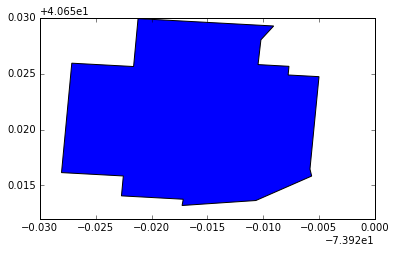

In [434]:
fig = plt.figure()
polygon = shapeData['geometry'][29]
print polygon
ax = fig.gca()
sample_patch = PolygonPatch(polygon)
ax.add_patch(sample_patch)
ax.axis('scaled')

(-74.299999999999997,
 -73.599999999999994,
 40.400000000000006,
 41.000000000000007)

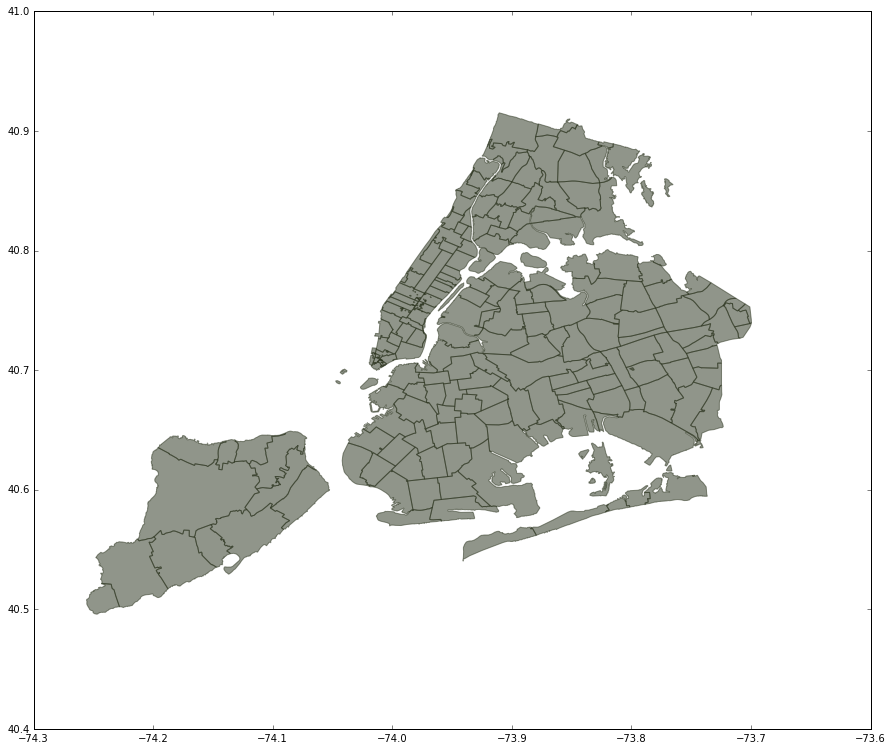

In [448]:
fig = plt.figure(figsize=(15,15))

# for i in shapeData:
#     print i

for i in range(len(shapeData)):
    poly = shapeData['geometry'][i]
    postcode = shapeData['ZIP'][i]
    ax = fig.gca()
    color = GREEN
    ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5))
#     if postcode in list(set(mydata2['zips'])):
#         color = kelly_colors_hex[int(mydata2[mydata2['zips']==postcode]['Cluster Number'])+1]
        #ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5,))
ax.axis('scaled')